In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
from IPython.display import clear_output
import matplotlib.pyplot as plt
from progressbar import progressbar as pb

data = pd.read_csv('/content/drive/My Drive/Embeddings/big_data_fix.csv', index_col=False)
data.head()

,0,1,2,3,4,5
0,Совещательный орган при императоре в начале XX в,Сенат,Государственный совет,Консилия министров,Верховный тайный совет,2
1,Министр внутренних дел с 1904 г либерал автор ...,Лорис Меликов,Святополк Мирский,Милюков,Витте,2
2,Какое из названных событий произошло 27 января...,подрыв флагманского корабля Петропавловск,высадка японских войск на Ляодунском полуострове,героический бой Варяга и Корейца,заключение Портсмутского мирного договора,3
3,Что из названного относится к результатам перв...,появление многопартийности,формирование конституционной монархии,ликвидация сословного строя,введение рабочего контроля за производством,1
4,Творчество поэтов Гумилева Ахматовой Мандельшт...,акмеизму,футуризму,импрессионизму,реализму,1


In [0]:
import pickle

with open('/content/drive/My Drive/Embeddings/elmo_embed_big.pickle', 'rb') as f:
    elmo_embs = pickle.load(f)

elmo_embs = np.array(elmo_embs)

with open('/content/drive/My Drive/Embeddings/bert_embed_big.pickle', 'rb') as f:
    bert_embs = pickle.load(f)

bert_embs = np.array(bert_embs)

with open('/content/drive/My Drive/Embeddings/fasttext_embed_big.pickle', 'rb') as f:
    fasttext_embs = pickle.load(f)

fasttext_embs = np.array(fasttext_embs)

with open('/content/drive/My Drive/Embeddings/rusvec_embed_big.pickle', 'rb') as f:
    rusvec_embs = pickle.load(f)

rusvec_embs = np.array(rusvec_embs)

In [0]:
def get_samples(data, embeddings, train_part=0.75):
    predata = np.zeros((embeddings.shape[0] * 4, embeddings.shape[2] * 2))
    target = []

    for i in range(len(data)):
        for j in range(1,5):
            cur_targ = 1 if j == int(data.iloc[i,5]) else 0
            cur_vec = np.hstack((embeddings[i,0], embeddings[i,j]))
            predata[i*4+j-1] = cur_vec
            target.append(cur_targ)
            
    all_inds = np.arange(embeddings.shape[0])
    train_size = int(len(all_inds) * train_part)
    train_inds = np.random.choice(all_inds, size=train_size, replace=False)
    test_inds = np.array(list(set(all_inds) - set(train_inds)))
    
    X_train, X_test, y_train, y_test = [],[],[],[]

    for i in range(len(train_inds)):
        for j in range(4):
            X_train.append(predata[train_inds[i] * 4 + j])
            y_train.append(target[train_inds[i] * 4 + j])

    for i in range(len(test_inds)):
        for j in range(4):
            X_test.append(predata[test_inds[i] * 4 + j])
            y_test.append(target[test_inds[i] * 4 + j])
            
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [0]:
def get_batch(X_val, y_val, batch_sz=16):
    X_batches, y_batches = [], []
    
    samples_num = len(X_val) // 4
    samples_inds = np.arange(samples_num)
    np.random.shuffle(samples_inds)
    
    cur_x, cur_y = [], []
    
    for i, cur_ind in enumerate(samples_inds):
        if i % batch_sz < batch_sz-1:
            cur_x.extend(X_val[cur_ind:cur_ind+4])
            cur_y.extend(y_val[cur_ind:cur_ind+4])
        else:
            cur_x.extend(X_val[cur_ind:cur_ind+4])
            cur_y.extend(y_val[cur_ind:cur_ind+4])
            X_batches.append(cur_x)
            y_batches.append(cur_y)
            cur_x, cur_y = [], []
            
    X_batches.append(cur_x)
    y_batches.append(cur_y)
    
    return np.array(X_batches), np.array(y_batches)

In [0]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

def get_score(preds, targets):
    preds, targets = np.concatenate(preds, axis=0), np.concatenate(targets, axis=0)
    y_pred_splitted, y_target_splitted = [], []
    
    for i in range(len(preds) // 4):
        y_pred_splitted.append(np.argmax(preds[i*4:i*4+4]))
        y_target_splitted.append(np.argmax(targets[i*4:i*4+4]))
        
        
    accuracy = accuracy_score(y_target_splitted, y_pred_splitted)
    precision_macro = precision_score(y_target_splitted, y_pred_splitted, average='macro')
    precision_micro = precision_score(y_target_splitted, y_pred_splitted, average='micro')
    f1_macro = f1_score(y_target_splitted, y_pred_splitted, average='macro')
    f1_micro = f1_score(y_target_splitted, y_pred_splitted, average='micro')
    
    return accuracy, precision_macro, precision_micro, f1_macro, f1_micro

In [0]:
import torch
import torch.nn as nn

class SiameseNet(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.left = nn.Sequential(
                                nn.Linear(embed_size, embed_size * 3 // 4),
                                nn.ReLU(),
                                nn.Dropout(0.3),
                                nn.Linear(embed_size * 3 // 4, embed_size // 2),
                                nn.ReLU(),
                                nn.Dropout(0.3))
            
        self.right = nn.Sequential(
                                nn.Linear(embed_size, embed_size * 3 // 4),
                                nn.ReLU(),
                                nn.Dropout(0.3),
                                nn.Linear(embed_size * 3 // 4, embed_size // 2),
                                nn.ReLU(),
                                nn.Dropout(0.3))
        
        self.center = nn.Sequential(
                                nn.Linear(embed_size, embed_size // 2),
                                nn.ReLU(),
                                nn.Dropout(0.3),
                                nn.Linear(embed_size // 2, embed_size // 4),
                                nn.ReLU(),
                                nn.Dropout(0.3),
                                nn.Linear(embed_size // 4, 1),
                                nn.Sigmoid())
            
    def forward(self, q, a):
        left = self.left(q)
        right = self.right(a)
        x = torch.cat((left, right), 1)
        out = self.center(x)
        
        return out

In [0]:
def train(model, optimizer, X_train, y_train, batch_size):
    train_loss, all_preds, all_tests = [], [], []
    model.train()
    
    X_batches, y_batches = get_batch(X_train, y_train, batch_size)

    for batch in zip(X_batches, y_batches):
        X_batch, y_batch = batch
        X_batch, y_batch = np.array(X_batch), np.array(y_batch)
        embed_shape_tr = X_batch.shape[1] // 2
        
        X_batch = torch.from_numpy(X_batch).type(torch.cuda.FloatTensor)
        y_batch = torch.from_numpy(y_batch).type(torch.cuda.LongTensor)
    
        optimizer.zero_grad()
        y_pred = model(X_batch[:,:embed_shape_tr], X_batch[:, embed_shape_tr:])[:,0]

        loss = loss_fn(y_pred, y_batch.type(torch.cuda.FloatTensor))
        
        train_loss.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        all_preds.append(y_pred.detach().cpu().numpy())
        all_tests.append(y_batch.cpu().numpy())
    
    score = get_score(np.array(all_preds), np.array(all_tests))
        
    return np.mean(train_loss), list(score)

In [0]:
def validate(model, optimizer, X_test, y_test, batch_size):
    val_loss, all_preds, all_tests = [], [], []
    model.eval()
    
    X_batches, y_batches = get_batch(X_test, y_test, batch_size)
  
    
    for batch in zip(X_batches, y_batches):
        X_batch, y_batch = batch
        X_batch, y_batch = np.array(X_batch), np.array(y_batch)
        embed_shape_tr = X_batch.shape[1] // 2
        
        X_batch = torch.from_numpy(X_batch).type(torch.cuda.FloatTensor)
        y_batch = torch.from_numpy(y_batch).type(torch.cuda.LongTensor)
    
        y_pred = model(X_batch[:,:embed_shape_tr], X_batch[:, embed_shape_tr:])[:,0]
        
        loss = loss_fn(y_pred, y_batch.type(torch.cuda.FloatTensor))
        
        val_loss.append(loss.item())
        all_preds.append(y_pred.detach().cpu().numpy())
        all_tests.append(y_batch.cpu().numpy())
        
    score = get_score(np.array(all_preds), np.array(all_tests))
        
    return np.mean(val_loss), list(score)

In [0]:
def launch_net(model, optimizer, X_train, y_train, X_test, y_test,
               train_batch=64, test_batch=16, epochs=25):
    all_train_loss, all_val_loss = [], []
    all_train_acc, all_val_acc = [], []
    all_scores = []
    max_acc = 0

    for epoch in pb(range(epochs)):
        cur_train = train(model, optimizer, X_train, y_train, train_batch)
        cur_val = validate(model, optimizer, X_test, y_test, test_batch)
        all_train_loss.append(cur_train[0])
        all_train_acc.append(cur_train[1][0])
        all_val_loss.append(cur_val[0])
        all_val_acc.append(cur_val[1][0])
        all_scores.append(cur_val[1])
        max_acc = cur_val[1][0] if cur_val[1][0] > max_acc else max_acc
        clear_output()
        print('Epoch {}:'.format(epoch+1))
        print("Train loss: {}".format(cur_train[0]))
        print("Validation loss: {}".format(cur_val[0]))
        print("Train accuracy: {}".format(cur_train[1][0]))
        print("Validation accuracy: {}".format(cur_val[1][0]))
        print("Max validation accuracy: {}".format(max_acc))
        
        f, axarr = plt.subplots(1,2, figsize=(20,10))

        axarr[0].plot(all_train_loss, label='Train loss')
        axarr[0].plot(all_val_loss, label='Val loss')
        axarr[0].grid()
        axarr[0].legend(fontsize=15)
        axarr[0].set_title('Loss after epoch #{}'.format(epoch+1), size=15)

        axarr[1].plot(all_train_acc, label='Train accuracy')
        axarr[1].plot(all_val_acc, label='Val accuracy')
        axarr[1].grid()
        axarr[1].legend(fontsize=15)
        axarr[1].set_title('Accuracy after epoch #{}'.format(epoch+1), size=15)
        plt.show()
        
    all_scores = np.max(np.array(all_scores), axis=0)
    return all_scores

In [0]:
results_dict = {'RusVectores': [], 'FastText': [], 'ELMO': [], 'BERT': []}
epochs = 20

# Fasttext

In [0]:
embeddings = fasttext_embs
X_train, X_test, y_train, y_test = get_samples(data, embeddings)

In [0]:
model = SiameseNet(embeddings.shape[2]).cuda()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()

Epoch 20:
Train loss: 0.13571978510393726
Validation loss: 1.7314223138297475
Train accuracy: 0.7544879640962873
Validation accuracy: 0.2857142857142857
Max validation accuracy: 0.3016212909146528


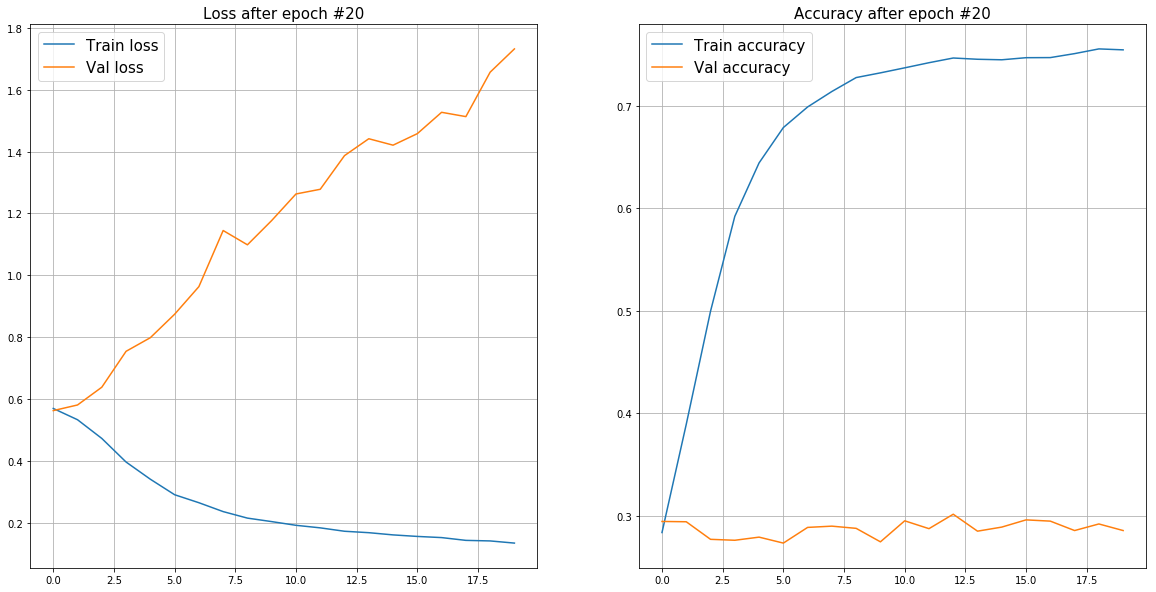

100% (20 of 20) |########################| Elapsed Time: 0:00:33 Time:  0:00:33


In [34]:
results = launch_net(model, optimizer, X_train, y_train, X_test, y_test, 64, 16, epochs)
results_dict['FastText'] = results

# ELMO

In [0]:
embeddings = elmo_embs
X_train, X_test, y_train, y_test = get_samples(data, embeddings)

In [0]:
model = SiameseNet(embeddings.shape[2]).cuda()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()

Epoch 20:
Train loss: 0.08093345395059555
Validation loss: 2.5173447748509847
Train accuracy: 0.7780497756017952
Validation accuracy: 0.31263383297644537
Max validation accuracy: 0.323646375038238


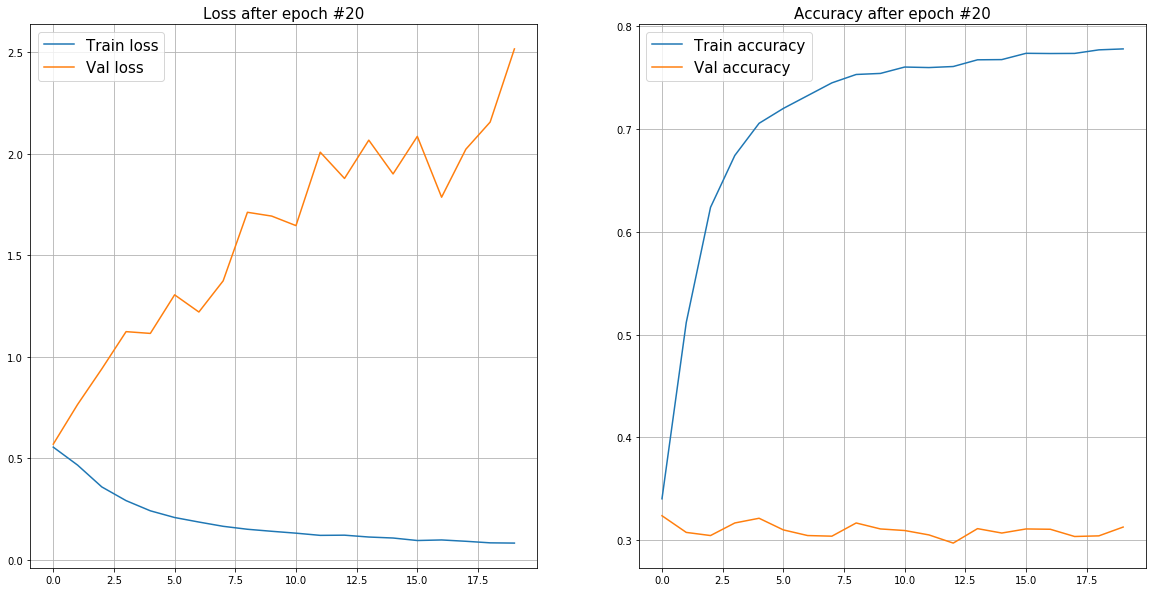

100% (20 of 20) |########################| Elapsed Time: 0:00:44 Time:  0:00:44


In [37]:
results = launch_net(model, optimizer, X_train, y_train, X_test, y_test, 64, 16, epochs)
results_dict['ELMO'] = results

# BERT

In [0]:
embeddings = bert_embs
X_train, X_test, y_train, y_test = get_samples(data, embeddings)

In [0]:
model = SiameseNet(embeddings.shape[2]).cuda()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()

Epoch 20:
Train loss: 0.2074554543700311
Validation loss: 1.7262281345158088
Train accuracy: 0.7236842105263158
Validation accuracy: 0.2994799632915265
Max validation accuracy: 0.31079840929947994


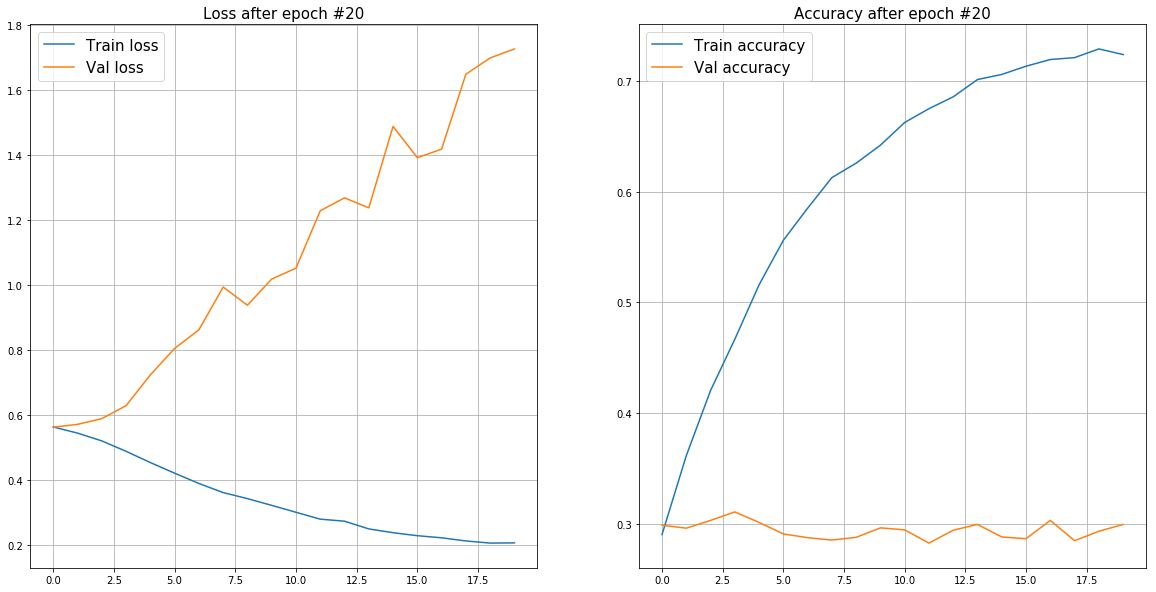

100% (20 of 20) |########################| Elapsed Time: 0:00:39 Time:  0:00:39


In [40]:
results = launch_net(model, optimizer, X_train, y_train, X_test, y_test, 64, 16, epochs)
results_dict['BERT'] = results

# RusVectores

In [0]:
embeddings = rusvec_embs
X_train, X_test, y_train, y_test = get_samples(data, embeddings)

In [0]:
model = SiameseNet(embeddings.shape[2]).cuda()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.BCELoss()

Epoch 20:
Train loss: 0.20204827102360787
Validation loss: 1.9926893595352912
Train accuracy: 0.7042023663810689
Validation accuracy: 0.2844906699296421
Max validation accuracy: 0.29917405934536556


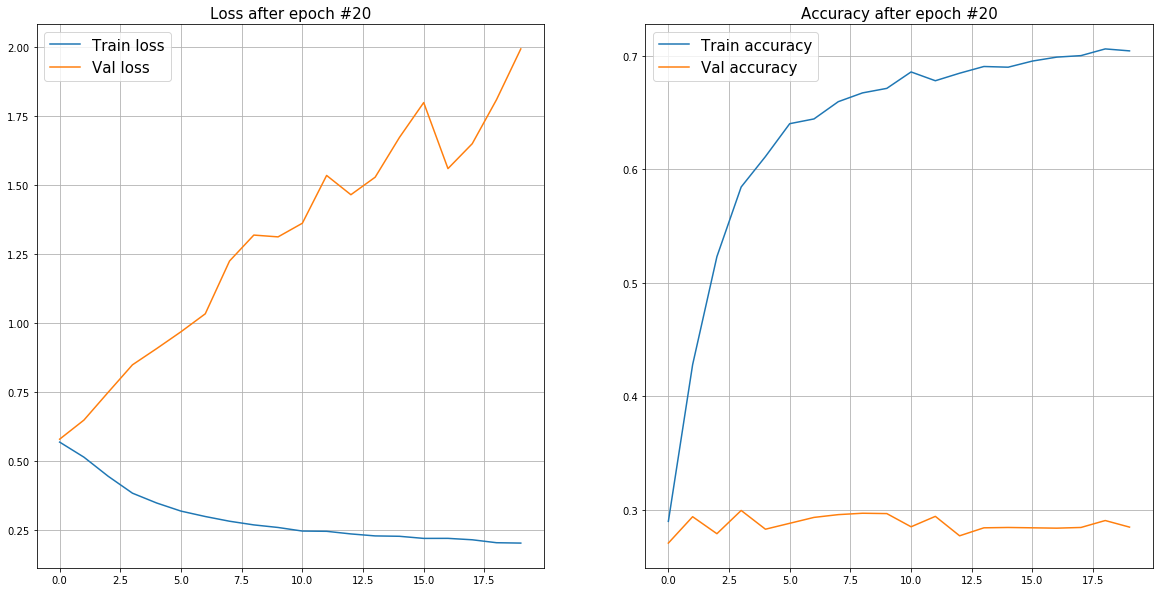

100% (20 of 20) |########################| Elapsed Time: 0:00:31 Time:  0:00:31


In [43]:
results = launch_net(model, optimizer, X_train, y_train, X_test, y_test, 64, 32, epochs)
results_dict['RusVectores'] = results

In [44]:
results = pd.DataFrame(data=results_dict, columns=list(results_dict.keys()), \
                       index=['Accuracy', 'Precision Macro', 'Precision Micro', 'F1 Macro', 'F1 Micro'])
results

,RusVectores,FastText,ELMO,BERT
Accuracy,0.299174,0.301621,0.323646,0.310798
Precision Macro,0.290026,0.302481,0.322553,0.310905
Precision Micro,0.299174,0.301621,0.323646,0.310798
F1 Macro,0.286980,0.294818,0.315236,0.303774
F1 Micro,0.299174,0.301621,0.323646,0.310798
